<a href="https://colab.research.google.com/github/TheUnknown477/Fraud-detection-using-deep-learning/blob/main/fraud_detection_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install torch torchvision torchaudio
!pip install pandas numpy scikit-learn
!pip install river


In [3]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Create the kaggle.json file with your credentials
# Replace 'YOUR_KAGGLE_USERNAME' and 'YOUR_KAGGLE_API_KEY' with your actual credentials
kaggle_credentials = {"username":"hamishch","key":"9a14e2f859f3c0d69cdb2c7ffeb9f34b"}

import json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials have been set up.")

Kaggle API credentials have been set up.


In [4]:
import os

os.makedirs('/root/.kaggle', exist_ok=True)
os.chmod('/root/.kaggle/kaggle.json', 600)

In [5]:
!kaggle competitions download -c ieee-fraud-detection -p /content/data
!unzip -q /content/data/ieee-fraud-detection.zip -d /content/data


  0% 0.00/118M [00:00<?, ?B/s]
100% 118M/118M [00:00<00:00, 1.33GB/s]


In [6]:
import pandas as pd

train_tr = pd.read_csv('/content/data/train_transaction.csv')
train_id = pd.read_csv('/content/data/train_identity.csv')

data = train_tr.merge(train_id, on='TransactionID', how='left')


In [7]:
target_col = 'isFraud'
time_col = 'TransactionDT'

feature_cols = [
    'TransactionDT', 'TransactionAmt', 'ProductCD',
    'card1','card2','card3','card4',
    'addr1','DeviceType',
    'V12','V13','V14','V15'  # example; adjust as needed
]

data = data[feature_cols + [target_col]]


In [8]:
data = data.sort_values(time_col).reset_index(drop=True)


In [9]:
import numpy as np

# Simple missing handling
for col in data.columns:
    if data[col].dtype == 'O':
        data[col] = data[col].fillna('missing')
    else:
        data[col] = data[col].fillna(data[col].median())


In [10]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['ProductCD','card4','DeviceType']
encoders_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders_dict[col] = le

num_cols = [c for c in data.columns if c not in cat_cols + [target_col]]
num_cols.remove(time_col)  # keep TransactionDT separate

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])


In [12]:
split_idx = int(0.6 * len(data))
hist_df = data.iloc[:split_idx].reset_index(drop=True)
stream_df = data.iloc[split_idx:].reset_index(drop=True)


In [13]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature_input_cols = num_cols + cat_cols  # exclude time + target

class FraudDataset(Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df[feature_input_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, input_dim, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [14]:
train_ds = FraudDataset(hist_df)
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True)

model = MLP(input_dim=len(feature_input_cols)).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [15]:
for epoch in range(5):  # start small
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1,1)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(X_batch)
    print(f"Epoch {epoch+1}, loss={total_loss/len(train_ds):.4f}")


Epoch 1, loss=0.2326
Epoch 2, loss=0.1396
Epoch 3, loss=0.1368
Epoch 4, loss=0.1354
Epoch 5, loss=0.1345


In [16]:
import torch.nn.functional as F

def mc_predict(model, X, T=20):
    model.eval()  # Put model in evaluation mode to handle BatchNorm correctly with single samples
    # Manually enable dropout for MC dropout
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train() # Re-enable dropout layers

    probs = []
    with torch.no_grad():
        for _ in range(T):
            p = model(X).cpu().numpy()
            probs.append(p)

    # Ensure model is back to proper eval state after MC dropout predictions if it's used elsewhere
    model.eval()

    probs = np.stack(probs, axis=0)  # [T, batch, 1]
    mean_p = probs.mean(axis=0).reshape(-1)
    var_p = probs.var(axis=0).reshape(-1)
    return mean_p, var_p

In [17]:
delay_steps = 1000  # tune as you like
replay_buffer = []  # will store (features, label)

from collections import deque
label_queue = deque()  # stores (time_index, true_label)


In [18]:
def stream_generator(df):
    for i, row in df.iterrows():
        X = torch.tensor(row[feature_input_cols].values, dtype=torch.float32).unsqueeze(0).to(device)
        y = int(row[target_col])
        yield i, X, y


In [19]:
from river.drift import ADWIN

adwin = ADWIN()
errors = []          # store 0/1 error
drift_points = []    # indices where drift is detected


In [20]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

T_mc = 20
review_threshold_uncert = 0.02  # variance threshold (tune)
batch_update_size = 256

metrics_log = []
recent_labeled = []

# Buffer to store true labels and predictions for chunk evaluation
metrics_eval_buffer_true = []
metrics_eval_buffer_pred = []

for i, (idx, X, true_y) in enumerate(stream_generator(stream_df)):
    # 1. Predict with MC Dropout
    mean_p, var_p = mc_predict(model, X, T=T_mc)
    # Explicitly extract the scalar value before converting to int
    pred_label = int(mean_p.item() >= 0.5)

    # 2. Simulate sending to review if uncertain
    if var_p[0] > review_threshold_uncert:
        # mark as "review candidate" (always used for training when label arrives)
        sent_to_review = True
    else:
        sent_to_review = False

    # 3. Push true label into delayed queue
    label_queue.append((idx, true_y, X.cpu(), sent_to_review))

    # Store for metrics evaluation
    metrics_eval_buffer_true.append(true_y)
    metrics_eval_buffer_pred.append(mean_p.item()) # Store probability for AUC

    # 4. When enough steps passed, reveal label and update model + drift detector
    if len(label_queue) > delay_steps:
        past_idx, past_y, past_X_cpu, was_reviewed = label_queue.popleft()
        past_X = past_X_cpu.to(device)
        y_tensor = torch.tensor([[past_y]], dtype=torch.float32, device=device)

        # Compute error for ADWIN
        with torch.no_grad():
            out = model(past_X)
        err = int((out.item() >= 0.5) != past_y)

        # Safely handle the return value of adwin.update()
        adwin_update_result = adwin.update(err)
        if adwin_update_result is not None:
            _, change_detected = adwin_update_result
        else:
            # If ADWIN returns None unexpectedly, assume no change detected
            change_detected = False

        if change_detected:
            drift_points.append(past_idx)
            # example adaptation: extra fine-tuning on recent labeled buffer
            print(f"Drift detected at stream index {past_idx}")

        # Online fine-tune only for "reviewed" or with some probability
        if was_reviewed:
            recent_labeled.append((past_X_cpu.numpy(), past_y))

        if len(recent_labeled) >= batch_update_size:
            batch = recent_labeled[-batch_update_size:]
            X_batch = torch.tensor([b[0].reshape(-1) for b in batch], dtype=torch.float32).to(device)
            y_batch = torch.tensor([b[1] for b in batch], dtype=torch.float32).view(-1,1).to(device)
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Log metrics every N steps for visualization
    log_interval = 1000
    if i > 0 and i % log_interval == 0:
        if len(metrics_eval_buffer_true) > 0 and len(np.unique(metrics_eval_buffer_true)) > 1:
            y_true_chunk = np.array(metrics_eval_buffer_true)
            y_score_chunk = np.array(metrics_eval_buffer_pred)

            pr, rc, _ = precision_recall_curve(y_true_chunk, y_score_chunk)
            pr_auc = auc(rc, pr)
            roc_auc = roc_auc_score(y_true_chunk, y_score_chunk)
            metrics_log.append((idx, pr_auc, roc_auc))

        # Clear buffers for the next interval
        metrics_eval_buffer_true = []
        metrics_eval_buffer_pred = []

    # Optionally, print progress every N steps
    if i % 10000 == 0 and i > 0:
        print(f"Processed {i} streamed samples")

Processed 10000 streamed samples
Processed 20000 streamed samples
Processed 30000 streamed samples
Processed 40000 streamed samples
Processed 50000 streamed samples
Processed 60000 streamed samples
Processed 70000 streamed samples
Processed 80000 streamed samples
Processed 90000 streamed samples
Processed 100000 streamed samples
Processed 110000 streamed samples
Processed 120000 streamed samples
Processed 130000 streamed samples
Processed 140000 streamed samples
Processed 150000 streamed samples
Processed 160000 streamed samples
Processed 170000 streamed samples
Processed 180000 streamed samples
Processed 190000 streamed samples
Processed 200000 streamed samples
Processed 210000 streamed samples
Processed 220000 streamed samples
Processed 230000 streamed samples


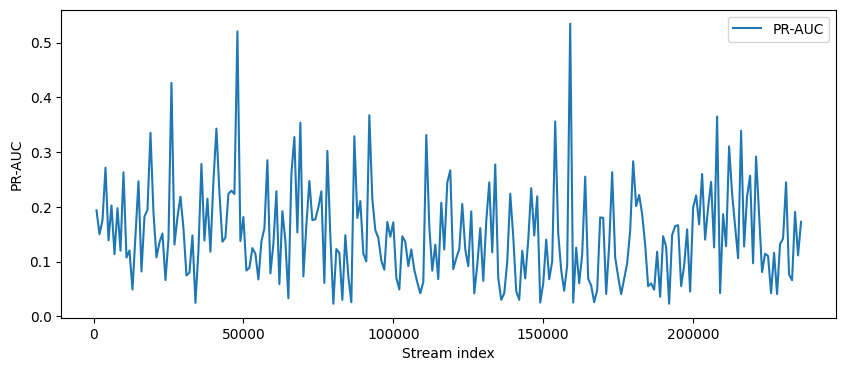

In [21]:
import matplotlib.pyplot as plt

indices = [m[0] for m in metrics_log]
pr_aucs = [m[1] for m in metrics_log]

plt.figure(figsize=(10,4))
plt.plot(indices, pr_aucs, label='PR-AUC')
for dp in drift_points:
    plt.axvline(dp, color='red', linestyle='--', alpha=0.4)
plt.xlabel('Stream index')
plt.ylabel('PR-AUC')
plt.legend()
plt.show()


In [22]:
pd.DataFrame(metrics_log).to_csv('results_M2.csv', index=False)

In [23]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc

def compute_chunk_metrics(y_true, y_score, fpr_target=0.05):
    """
    y_true: list/array of 0/1 labels
    y_score: list/array of predicted fraud probabilities
    """
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # ROC-AUC (guard against degenerate cases)
    try:
        roc = roc_auc_score(y_true, y_score)
    except ValueError:
        roc = np.nan

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)

    # recall at fixed FPR
    # approximate by scanning thresholds
    thresholds = np.unique(np.sort(y_score))
    best_recall = 0.0
    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        tn = ((y_pred == 0) & (y_true == 0)).sum()
        fpr = fp / (fp + tn + 1e-9)
        if fpr <= fpr_target:
            recall_at_fpr = tp / (tp + fn + 1e-9)
            if recall_at_fpr > best_recall:
                best_recall = recall_at_fpr

    return {
        "roc_auc": roc,
        "pr_auc": pr_auc,
        f"recall_at_fpr_{fpr_target}": best_recall
    }


In [24]:
def run_static_baseline(model, df, chunk_size=50000):
    model.eval()
    y_true_all, y_score_all = [], []
    metrics_log = []

    with torch.no_grad():
        for i, row in df.iterrows():
            X = torch.tensor(row[feature_input_cols].values,
                             dtype=torch.float32).unsqueeze(0).to(device)
            y = int(row[target_col])
            p = model(X).item()
            y_true_all.append(y)
            y_score_all.append(p)

            if (i + 1) % chunk_size == 0:
                m = compute_chunk_metrics(y_true_all, y_score_all)
                m["index"] = i
                metrics_log.append(m)
                print(f"Static baseline @ {i}: PR-AUC={m['pr_auc']:.4f}, ROC-AUC={m['roc_auc']:.4f}")
                y_true_all, y_score_all = [], []

    return metrics_log


In [25]:
static_metrics = run_static_baseline(model, stream_df)


Static baseline @ 49999: PR-AUC=0.1737, ROC-AUC=0.7789
Static baseline @ 99999: PR-AUC=0.1432, ROC-AUC=0.7613
Static baseline @ 149999: PR-AUC=0.1096, ROC-AUC=0.7256
Static baseline @ 199999: PR-AUC=0.1103, ROC-AUC=0.7396


In [30]:
def run_online_finetune(df, delay_steps=1000, chunk_size=50000,
                        lr=1e-4, batch_update_size=256):
    from collections import deque
    import numpy as np # Import numpy

    # fresh copy of model (start from initial static weights)
    online_model = MLP(input_dim=len(feature_input_cols)).to(device)
    online_model.load_state_dict(model.state_dict())  # start from pre-trained
    optimizer = torch.optim.Adam(online_model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    label_queue = deque()
    replay_buffer = []
    y_true_chunk, y_score_chunk = [], []
    metrics_log = []

    for i, row in df.iterrows():
        X = torch.tensor(row[feature_input_cols].values,
                         dtype=torch.float32).unsqueeze(0).to(device)
        y = int(row[target_col])

        # predict
        online_model.eval()
        with torch.no_grad():
            p = online_model(X).item()

        y_true_chunk.append(y)
        y_score_chunk.append(p)

        # push label for delayed reveal
        label_queue.append((X.cpu(), y))

        # reveal delayed label and update
        if len(label_queue) > delay_steps:
            past_X_cpu, past_y = label_queue.popleft()
            past_X = past_X_cpu.to(device)
            y_tensor = torch.tensor([[past_y]], dtype=torch.float32, device=device)

            # add to replay buffer
            replay_buffer.append((past_X_cpu.numpy(), past_y))

            if len(replay_buffer) >= batch_update_size:
                batch = replay_buffer[-batch_update_size:]
                # Convert list of arrays to a single numpy array first
                X_batch = torch.tensor(np.array([b[0].reshape(-1) for b in batch]),
                                       dtype=torch.float32).to(device)
                y_batch = torch.tensor(np.array([b[1] for b in batch]), # Also apply to y_batch for consistency
                                       dtype=torch.float32).view(-1,1).to(device)
                online_model.train()
                optimizer.zero_grad()
                y_pred = online_model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

        # periodic metrics
        if (i + 1) % chunk_size == 0:
            m = compute_chunk_metrics(y_true_chunk, y_score_chunk)
            m["index"] = i
            metrics_log.append(m)
            print(f"Online baseline @ {i}: PR-AUC={m['pr_auc']:.4f}, ROC-AUC={m['roc_auc']:.4f}")
            y_true_chunk, y_score_chunk = [], []

    return metrics_log

In [32]:
online_metrics = run_online_finetune(stream_df)

Online baseline @ 49999: PR-AUC=0.1322, ROC-AUC=0.7078
Online baseline @ 99999: PR-AUC=0.1030, ROC-AUC=0.6712
Online baseline @ 149999: PR-AUC=0.0830, ROC-AUC=0.6777
Online baseline @ 199999: PR-AUC=0.0855, ROC-AUC=0.6555


In [31]:
from river.drift import ADWIN
import numpy as np # Import numpy

def run_full_method(
    df,
    delay_steps=1000,
    chunk_size=50000,
    lr=1e-4,
    batch_update_size=256,
    T_mc=20,
    review_threshold_uncert=0.02,
):
    from collections import deque

    full_model = MLP(input_dim=len(feature_input_cols)).to(device)
    full_model.load_state_dict(model.state_dict())
    optimizer = torch.optim.Adam(full_model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    adwin = ADWIN()
    label_queue = deque()
    replay_buffer = []
    drift_points = []

    y_true_chunk, y_score_chunk = [], []
    metrics_log = []

    for i, row in df.iterrows():
        X = torch.tensor(
            row[feature_input_cols].values, dtype=torch.float32
        ).unsqueeze(0).to(device)
        y = int(row[target_col])

        # MC Dropout prediction
        mean_p, var_p = mc_predict(full_model, X, T=T_mc)
        p = float(mean_p[0])
        uncert = float(var_p[0])

        # decide if sent to "review"
        sent_to_review = uncert > review_threshold_uncert

        y_true_chunk.append(y)
        y_score_chunk.append(p)

        # queue with delay
        label_queue.append((X.cpu(), y, sent_to_review))

        # reveal and update
        if len(label_queue) > delay_steps:
            past_X_cpu, past_y, was_reviewed = label_queue.popleft()
            past_X = past_X_cpu.to(device)
            y_tensor = torch.tensor([[past_y]], dtype=torch.float32, device=device)

            # compute error for drift detector
            full_model.eval()
            with torch.no_grad():
                out = full_model(past_X).item()
            err = int((out >= 0.5) != past_y)

            # Correctly handle ADWIN update result
            adwin_update_result = adwin.update(err)
            change_detected = False
            if adwin_update_result is not None:
                _, change_detected = adwin_update_result

            if change_detected:
                drift_points.append(i)
                print(f"Drift detected at stream index {i}")

            # only reviewed (or optionally sampled) go to training
            if was_reviewed:
                replay_buffer.append((past_X_cpu.numpy(), past_y))

            # adaptation: stronger training if drift was detected recently
            if len(replay_buffer) >= batch_update_size:
                batch = replay_buffer[-batch_update_size:]
                # Convert list of arrays to a single numpy array first
                X_batch = torch.tensor(
                    np.array([b[0].reshape(-1) for b in batch]), dtype=torch.float32
                ).to(device)
                y_batch = (
                    torch.tensor(np.array([b[1] for b in batch]), dtype=torch.float32) # Also apply to y_batch for consistency
                    .view(-1, 1)
                    .to(device)
                )
                full_model.train()
                optimizer.zero_grad()
                y_pred = full_model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

        # periodic logging
        if (i + 1) % chunk_size == 0:
            m = compute_chunk_metrics(y_true_chunk, y_score_chunk)
            m["index"] = i
            m["num_drift"] = len(drift_points)
            metrics_log.append(m)
            print(
                f"Full method @ {i}: PR-AUC={m['pr_auc']:.4f}, ROC-AUC={m['roc_auc']:.4f}, drifts={len(drift_points)}"
            )
            y_true_chunk, y_score_chunk = [], []

    return metrics_log, drift_points

In [33]:
full_metrics, drift_points = run_full_method(stream_df)

Full method @ 49999: PR-AUC=0.1731, ROC-AUC=0.7771, drifts=0
Full method @ 99999: PR-AUC=0.1398, ROC-AUC=0.7591, drifts=0
Full method @ 149999: PR-AUC=0.1108, ROC-AUC=0.7237, drifts=0
Full method @ 199999: PR-AUC=0.1133, ROC-AUC=0.7392, drifts=0


In [37]:
def run_periodic_retrain(df,
                         delay_steps=1000,
                         chunk_size=50000,
                         retrain_every=50000,
                         window_size=200000):
    from collections import deque

    periodic_model = MLP(input_dim=len(feature_input_cols)).to(device)
    periodic_model.load_state_dict(model.state_dict())
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(periodic_model.parameters(), lr=1e-3)

    # store last window_size labeled points for retraining
    labeled_window = deque(maxlen=window_size)
    label_queue = deque()

    y_true_chunk, y_score_chunk = [], []
    metrics_log = []

    for i, row in df.iterrows():
        X = torch.tensor(row[feature_input_cols].values,
                         dtype=torch.float32).unsqueeze(0).to(device)
        y = int(row[target_col])

        periodic_model.eval()
        with torch.no_grad():
            p = periodic_model(X).item()

        y_true_chunk.append(y)
        y_score_chunk.append(p)

        label_queue.append((row[feature_input_cols].values.copy(), y))

        if len(label_queue) > delay_steps:
            past_X_np, past_y = label_queue.popleft()
            labeled_window.append((past_X_np, past_y))

        # retrain periodically from scratch on window
        if (i + 1) % retrain_every == 0 and len(labeled_window) > 1000:
            print(f"Retraining model at index {i}")
            periodic_model = MLP(input_dim=len(feature_input_cols)).to(device)
            optimizer = torch.optim.Adam(periodic_model.parameters(), lr=1e-3)
            dataset_X = torch.tensor([x for x, _ in labeled_window],
                                     dtype=torch.float32)
            dataset_y = torch.tensor([y for _, y in labeled_window],
                                     dtype=torch.float32).view(-1,1)
            dl = DataLoader(list(zip(dataset_X, dataset_y)),
                            batch_size=4096, shuffle=True)
            for epoch in range(2):  # short retrain
                periodic_model.train()
                for Xb, yb in dl:
                    Xb, yb = Xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = periodic_model(Xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()

        if (i + 1) % chunk_size == 0:
            m = compute_chunk_metrics(y_true_chunk, y_score_chunk)
            m["index"] = i
            metrics_log.append(m)
            print(f"Periodic baseline @ {i}: PR-AUC={m['pr_auc']:.4f}, ROC-AUC={m['roc_auc']:.4f}")
            y_true_chunk, y_score_chunk = [], []

    return metrics_log

In [38]:
periodic_metrics = run_periodic_retrain(stream_df)

Retraining model at index 49999
Periodic baseline @ 49999: PR-AUC=0.1737, ROC-AUC=0.7789
Retraining model at index 99999
Periodic baseline @ 99999: PR-AUC=0.0906, ROC-AUC=0.7179
Retraining model at index 149999
Periodic baseline @ 149999: PR-AUC=0.0690, ROC-AUC=0.6998
Retraining model at index 199999
Periodic baseline @ 199999: PR-AUC=0.0885, ROC-AUC=0.7295


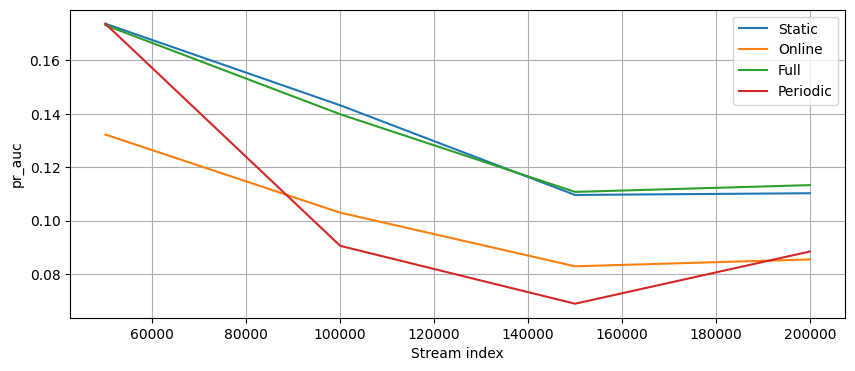

In [39]:
import matplotlib.pyplot as plt

def plot_metric_over_time(dfs, labels, metric='pr_auc'):
    plt.figure(figsize=(10,4))
    for df, label in zip(dfs, labels):
        plt.plot(df['index'], df[metric], label=label)
    plt.xlabel('Stream index')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# Convert metrics lists to DataFrames for easier plotting
static_df = pd.DataFrame(static_metrics)
online_df = pd.DataFrame(online_metrics)
full_df = pd.DataFrame(full_metrics)
periodic_df = pd.DataFrame(periodic_metrics)

plot_metric_over_time(
    [static_df, online_df, full_df, periodic_df],
    ['Static', 'Online', 'Full', 'Periodic'],
    metric='pr_auc'
)

In [40]:
import pandas as pd

static_df = pd.DataFrame(static_metrics)
static_df.to_csv('static_metrics.csv', index=False)

online_df = pd.DataFrame(online_metrics)
online_df.to_csv('online_metrics.csv', index=False)

full_df = pd.DataFrame(full_metrics)
full_df.to_csv('full_method_metrics.csv', index=False)

periodic_df = pd.DataFrame(periodic_metrics)
periodic_df.to_csv('periodic_metrics.csv', index=False)

In [41]:
torch.save(model.state_dict(), 'fraud_mlp.pth')


In [42]:
import joblib

joblib.dump(scaler, 'scaler.pkl')          # StandardScaler
joblib.dump(encoders_dict, 'encoders.pkl') # e.g., {'ProductCD': le_prod, 'card4': le_card4, 'DeviceType': le_dev}

['encoders.pkl']

In [43]:
feature_input_cols = num_cols + cat_cols  # same as used for training
joblib.dump(feature_input_cols, 'feature_cols.pkl')


['feature_cols.pkl']